# Import and Ingest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
df = pd.read_csv('final_raw_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df = df.drop(columns = ['Open', 'High', 'Low', 'Volume'])
df = df.rename(columns = {'Close': 'Price'})
print(df.shape)  # (123, 8)
df.tail()

(760, 27)


,Altcoin,BIT,Bitcoin Address,Bitcoin Investment,Bitcoin Mining,Bitcoin News,Bitcoin Price,Bitcoin Wallet,Bitcoin,Block,...,Digital Currency,Ethereum,Fiat money,Fork,Hash Rate,ICO,P2P,Private Key,Stablecoin,Price
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-26,0.00,85.54,31.27,3.30,24.49,3.30,6.48,15.0,6.09,31.92,...,3.20,4.80,9.69,50.00,4.48,47.31,51.87,26.39,3.85,41816.871094
2024-01-27,39.48,63.08,7.98,9.24,17.36,1.98,4.94,0.0,4.56,36.50,...,2.94,4.75,6.65,41.83,8.32,58.29,45.12,48.51,0.00,42120.054688
2024-01-28,24.78,59.76,21.09,7.26,20.15,1.98,5.70,0.0,6.24,46.00,...,2.52,5.13,15.96,40.42,0.00,56.55,62.98,66.33,1.32,42035.593750
2024-01-29,7.98,63.91,13.11,4.95,21.39,2.64,6.08,0.0,6.00,50.00,...,1.14,6.27,18.43,42.77,0.00,54.81,71.44,87.12,1.60,43288.246094
2024-01-30,9.24,64.74,40.47,10.23,19.22,2.42,5.70,0.0,6.00,48.00,...,3.36,5.89,13.30,43.24,0.00,63.51,78.96,87.12,1.96,42952.609375


# Split the Series into Training and Testing Data

In [3]:
nobs = 30
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(730, 27)
(30, 27)


# Check for Stationarity and Make the Time Series Stationary

In [4]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
        return True
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
        return False
# ADF Test on each column
stationary = True
for name, column in df_train.items():
    temp = adfuller_test(column, name=column.name)
    stationary = stationary and temp
    print('\n')
if stationary:
    print('Proceed')
else:
    print('Need differencing')

    Augmented Dickey-Fuller Test on "Altcoin" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.5143
 No. Lags Chosen       = 20
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BIT" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.9645
 No. Lags Chosen       = 7
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Bitcoin Address" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance 

## 1st difference

In [5]:
df_differenced = df_train.diff().dropna()
# ADF Test on each column of 1st Differences Dataframe
stationary = True
for name, column in df_differenced.items():
    temp = adfuller_test(column, name=column.name)
    stationary = stationary and temp
    print('\n')
if stationary:
    print('Proceed')
else:
    print('Need differencing')

    Augmented Dickey-Fuller Test on "Altcoin" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.8411
 No. Lags Chosen       = 19
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BIT" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.3737
 No. Lags Chosen       = 9
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Bitcoin Address" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

# Select the Order (P) of VAR model

In [6]:
model = VAR(df_differenced)
x = model.select_order(maxlags=25)
x.summary()

/Users/lichang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,112.8,112.9*,9.301e+48,112.8
1,109.8,114.7,5.033e+47,111.7
2,109.2,118.9,2.804e+47,113.0
3,109.4,123.7,3.393e+47,115.0
4,109.8,128.8,5.121e+47,117.1
5,109.7,133.5,5.013e+47,118.9
6,110.2,138.7,8.896e+47,121.2
7,110.3,143.6,1.216e+48,123.2
8,110.5,148.4,1.677e+48,125.1
9,110.6,153.2,2.311e+48,127.0


# Train the VAR Model of Selected Order(p)

In [7]:
model_order = 25
model_fitted = model.fit(model_order)
# model_fitted.summary()

# Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [8]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

Altcoin : 1.69
BIT : 1.72
Bitcoin Address : 1.66
Bitcoin Investment : 1.76
Bitcoin Mining : 2.07
Bitcoin News : 1.95
Bitcoin Price : 1.95
Bitcoin Wallet : 1.54
Bitcoin : 1.75
Block : 2.07
Blockchain : 1.9
BTC : 1.85
Crypto : 2.02
Cryptocurrency : 1.91
Cryptography : 1.81
DAPP : 2.08
DeFi : 1.84
Digital Currency : 1.72
Ethereum : 2.09
Fiat money : 1.73
Fork : 1.51
Hash Rate : 1.67
ICO : 1.33
P2P : 1.34
Private Key : 1.64
Stablecoin : 1.55
Price : 1.24


# Forecast VAR model using statsmodels

In [9]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

25


array([[-8.16000000e+00,  8.30000000e-01, -4.69000000e+00,
         3.19600000e+01, -1.26000000e+01,  2.15000000e+00,
         3.80000000e-01, -1.88000000e+01, -4.10000000e-01,
        -3.15000000e+00,  1.41000000e+00, -5.40000000e+00,
         7.80000000e-01,  3.20000000e-01, -7.10000000e-01,
         7.99000000e+00,  0.00000000e+00, -3.42000000e+00,
         4.29000000e+00,  3.85000000e+00, -3.50000000e+00,
         3.00000000e+00,  1.71600000e+01,  0.00000000e+00,
        -2.49400000e+01,  1.04000000e+00, -4.53781250e+02],
       [ 1.58400000e+01, -7.47000000e+00,  6.70000000e+00,
        -3.33200000e+01,  7.00000000e+00, -4.30000000e+00,
        -3.80000000e+00,  0.00000000e+00, -4.10000000e+00,
        -3.15000000e+00, -6.11000000e+00, -4.32000000e+00,
         2.34000000e+00,  6.40000000e-01, -2.48500000e+01,
        -6.58000000e+00,  0.00000000e+00, -9.90000000e-01,
        -9.36000000e+00, -1.50500000e+01,  2.00000000e+00,
        -2.40000000e-01, -2.80800000e+01, -2.61000000e+

In [10]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,Altcoin_1d,BIT_1d,Bitcoin Address_1d,Bitcoin Investment_1d,Bitcoin Mining_1d,Bitcoin News_1d,Bitcoin Price_1d,Bitcoin Wallet_1d,Bitcoin_1d,Block_1d,...,Digital Currency_1d,Ethereum_1d,Fiat money_1d,Fork_1d,Hash Rate_1d,ICO_1d,P2P_1d,Private Key_1d,Stablecoin_1d,Price_1d
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-01,-22.473634,7.064265,-3.457730,7.454116,7.004255,-25.724885,18.266084,143.849782,14.786483,50.239977,...,30.978085,27.503531,31.932177,-20.932756,-22.460818,67.398807,-58.505283,131.931433,33.944425,-10313.117536
2024-01-02,-21.344870,17.993438,-46.012036,-35.106736,32.510123,43.366522,5.338398,-155.373038,-0.214305,-21.697791,...,-7.813815,32.214792,-30.637980,54.228889,69.916158,-70.805775,11.476442,-141.435852,-6.787276,-202.126820
2024-01-03,115.903785,40.691500,-36.683824,0.615361,-27.809678,10.870232,33.234464,39.585598,39.277249,-3.346523,...,9.381673,23.092088,29.796508,-38.948103,-11.841537,16.009302,27.982194,31.352097,-8.418865,3024.496764
2024-01-04,-61.372802,11.285633,73.173066,66.846342,18.375996,10.051105,4.236355,58.917938,3.147219,-39.863984,...,-4.422777,0.150510,-58.608343,15.512201,-3.034824,36.383606,-23.464277,-62.717493,-5.982945,-1757.116196
2024-01-05,8.603742,-49.092560,143.725719,-60.282137,-43.913237,-11.144623,-20.593752,40.723595,-13.520609,23.055519,...,-18.999490,-41.842319,56.389833,5.831733,-23.013481,-80.797571,39.121398,-116.148181,-27.938335,-1843.991173
2024-01-06,-10.419843,11.122933,-31.939530,27.592249,15.154895,-28.221281,-15.680532,-35.778090,-12.404955,4.715309,...,-1.689444,-24.081948,-12.319723,-23.807321,-51.185878,13.158437,67.471893,234.307099,30.219311,2946.058768
2024-01-07,17.201324,-6.470164,-12.895316,-81.005917,34.112930,-9.534811,-20.285716,-139.017475,-27.227908,-11.986574,...,-13.030383,-9.385213,1.993260,47.405319,52.541479,-33.624183,0.334155,-134.894452,-16.164611,3713.552844
2024-01-08,29.690626,-12.818455,-58.027737,94.929267,-61.129088,-25.031933,-11.834650,74.128129,-2.526196,41.856683,...,-0.889472,11.768510,27.301782,-65.241832,3.743977,91.865680,-15.921898,74.075720,16.040593,1850.404982
2024-01-09,-63.321110,12.013800,-49.918765,5.170221,73.290397,34.248999,3.569914,-82.224646,3.242963,13.621171,...,7.470455,-11.375557,-48.954670,37.454165,8.166109,-69.256387,-33.363953,4.127676,0.813702,6531.474743


# Invert the transformation to get the real forecast

In [11]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [12]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)
cols = [s + '_forecast' for s in df.columns.values.tolist()]
df_results.loc[:, cols]

,Altcoin_forecast,BIT_forecast,Bitcoin Address_forecast,Bitcoin Investment_forecast,Bitcoin Mining_forecast,Bitcoin News_forecast,Bitcoin Price_forecast,Bitcoin Wallet_forecast,Bitcoin_forecast,Block_forecast,...,Digital Currency_forecast,Ethereum_forecast,Fiat money_forecast,Fork_forecast,Hash Rate_forecast,ICO_forecast,P2P_forecast,Private Key_forecast,Stablecoin_forecast,Price_forecast
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-01,-2.673634,66.824265,13.942270,35.054116,32.844255,-16.604885,29.486084,143.849782,25.146483,67.389977,...,32.938085,38.003531,38.732177,25.707244,-22.460818,126.398807,-32.665283,150.131433,36.394425,31952.069964
2024-01-02,-24.018504,84.817704,-32.069766,-0.052620,65.354378,26.761637,34.824482,-11.523256,24.932178,45.692186,...,25.124270,70.218322,8.094197,79.936133,47.455340,55.593032,-21.188841,8.695580,29.607148,31749.943144
2024-01-03,91.885280,125.509204,-68.753590,0.562741,37.544700,37.631869,68.058947,28.062342,64.209427,42.345663,...,34.505943,93.310410,37.890705,40.988030,35.613803,71.602333,6.793352,40.047677,21.188283,34774.439908
2024-01-04,30.512479,136.794837,4.419476,67.409083,55.920697,47.682974,72.295301,86.980281,67.356647,2.481679,...,30.083166,93.460920,-20.717638,56.500231,32.578979,107.985939,-16.670925,-22.669815,15.205338,33017.323712
2024-01-05,39.116220,87.702277,148.145196,7.126946,12.007459,36.538351,51.701549,127.703875,53.836038,25.537198,...,11.083676,51.618602,35.672195,62.331964,9.565498,27.188369,22.450473,-138.817997,-12.732997,31173.332539
2024-01-06,28.696378,98.825210,116.205666,34.719195,27.162354,8.317070,36.021017,91.925785,41.431083,30.252507,...,9.394232,27.536654,23.352472,38.524643,-41.620379,40.346805,89.922366,95.489102,17.486314,34119.391307
2024-01-07,45.897701,92.355047,103.310350,-46.286722,61.275284,-1.217742,15.735302,-47.091690,14.203175,18.265933,...,-3.636151,18.151441,25.345732,85.929962,10.921100,6.722622,90.256521,-39.405350,1.321703,37832.944151
2024-01-08,75.588328,79.536592,45.282613,48.642545,0.146196,-26.249675,3.900652,27.036439,11.676978,60.122616,...,-4.525623,29.919951,52.647514,20.688130,14.665077,98.588303,74.334623,34.670370,17.362296,39683.349133
2024-01-09,12.267218,91.550392,-4.636152,53.812765,73.436593,7.999325,7.470566,-55.188207,14.919942,73.743787,...,2.944832,18.544394,3.692845,58.142296,22.831186,29.331915,40.970669,38.798046,18.175998,46214.823876


# Plot of Forecast vs Actuals

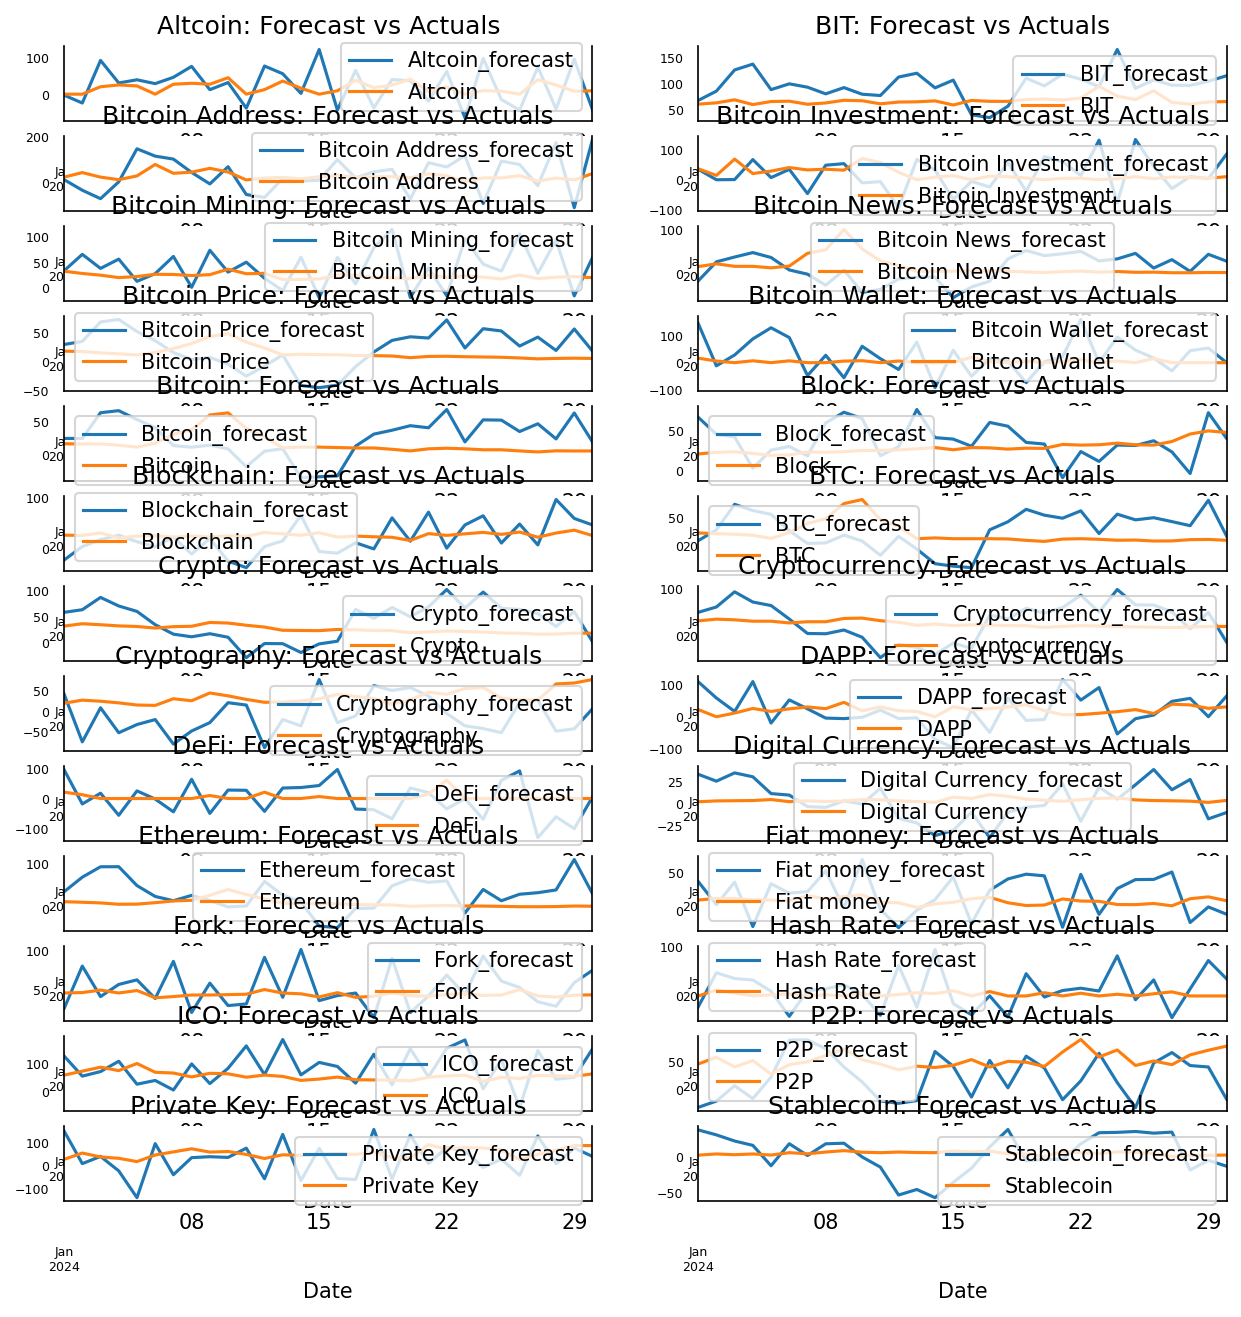

In [13]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

#plt.tight_layout();

# Evaluate the Forecasts

In [14]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'me':me, 'mae': mae, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [15]:
for col in df.columns.values.tolist():
    print('\nForecast Accuracy of: ' + col)
    accuracy_prod = forecast_accuracy(df_results[col + '_forecast'].values, df_test[col].values)
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))


Forecast Accuracy of: Altcoin
me :  6.466
mae :  39.2482
rmse :  48.1875
corr :  0.355
minmax :  inf

Forecast Accuracy of: BIT
me :  29.1594
mae :  33.7604
rmse :  38.9688
corr :  0.1615
minmax :  0.3264

Forecast Accuracy of: Bitcoin Address
me :  6.5785
mae :  59.0283
rmse :  73.5918
corr :  0.3142
minmax :  1.6047

Forecast Accuracy of: Bitcoin Investment
me :  -0.0768
mae :  49.4317
rmse :  61.6605
corr :  -0.194
minmax :  inf

Forecast Accuracy of: Bitcoin Mining
me :  17.626
mae :  33.3931
rmse :  40.9299
corr :  0.1142
minmax :  0.7717

Forecast Accuracy of: Bitcoin News
me :  -3.8103
mae :  36.2387
rmse :  43.1344
corr :  -0.3448
minmax :  1.6763

Forecast Accuracy of: Bitcoin Price
me :  7.0983
mae :  33.241
rmse :  37.881
corr :  -0.3614
minmax :  1.1595

Forecast Accuracy of: Bitcoin Wallet
me :  21.8077
mae :  50.2528
rmse :  63.9736
corr :  0.1642
minmax :  inf

Forecast Accuracy of: Bitcoin
me :  8.886
mae :  32.9476
rmse :  37.2318
corr :  -0.3089
minmax :  1.0255

For

/var/folders/4h/_njzjctj4c7_9q_c0xpcph4c0000gn/T/ipykernel_46384/3252965265.py:11: RuntimeWarning: divide by zero encountered in divide
  minmax = 1 - np.mean(mins/maxs)             # minmax


# Writing model hyperparameter and metrics to file

In [16]:
with open('metric_frame.csv', 'w') as file:
    file.write('Order,Mean Error,MAE,RMSE,CORR,MINMAX')

In [17]:
with open('metric_frame.csv', 'a') as file:
    line = str(model_order)
    for k, v in accuracy_prod.items():
        line += ',' + str(v)
    file.write('\n' + line)